In [288]:
import statsmodels.formula.api as smf
import sklearn
import sklearn.tree
import sklearn.ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [289]:
df=pd.read_csv('data/dev/dev-clean-whisper-large-v2-hypotheses.csv')
test_df=pd.read_csv('data/test/test-clean-whisper-large-v2-hypotheses.csv')
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78


In [290]:
df.loc[~df['word'].str.isalnum(), 'word'].unique(), test_df.loc[~test_df['word'].str.isalnum(), 'word'].unique()

(array(['$5', '.', 'archeology</span>', '£130', '£500', '£100', '$15'],
       dtype=object),
 array(['.', '$250000', '$300', '$60', '$150'], dtype=object))

Ignore str "."

In [291]:
print(df.shape, test_df.shape)
for col in ['word', 'prev_word', 'next_word']:
    df=df[df[col]!='.']
    test_df=test_df[test_df[col]!='.']
print(df.shape, test_df.shape)


(55242, 10) (54460, 10)
(55232, 10) (54450, 10)


Notice how imbalanced the dataset is: there are far more hits than insertions or substitutions.

In [292]:
df.shape

(55232, 10)

In [293]:
df['edit_type'].value_counts(), len(df), df['edit_type'].value_counts()/len(df)

(edit_type
 0.0    53704
 1.0      885
 3.0      643
 Name: count, dtype: int64,
 55232,
 edit_type
 0.0    0.972335
 1.0    0.016023
 3.0    0.011642
 Name: count, dtype: float64)

# Data preprocessing
- Represent Part of Speech as one-hot column
- Add feature for word length
- Add feature for word==next/prev_word
- Add Zipf frequencies for start/end of sentence tokens.

There are three "Part of Speech" columns: `word_pos` (for the current word), `prev_word_pos` and `next_word_pos`.
Generate list of all unique parts of speech from across all three columns.

In [294]:
all_pos = set()
pos_cols = [col for col in df.columns if col.endswith('pos')]
for col in pos_cols:
    all_pos.update(df[col].unique())
    all_pos.update(test_df[col].unique())
all_pos = list(all_pos)+['<s>', '</s>']
all_pos.sort()

all_pos

['$',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

To use Part of Speech as a feature for training, we need to represent it numerically in some way, since it's a categorical variable. Let's create a one-hot encoding by making a separate column for each part of speech.

In [295]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_df.columns.tolist()
df=pd.concat([df, pos_onehot_df], axis=1)
df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82,...,0,1,0,0,0,0,0,0,0,0
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27,...,0,0,0,0,0,0,0,0,0,0
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36,...,0,0,0,0,0,0,0,0,0,0
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36,...,0,0,0,0,0,0,0,0,0,0
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,thy,love,knot,1.0,NN,NN,NN,4.11,5.82,3.72,...,0,0,0,0,0,0,0,0,0,0
55238,knot,thy,on,1.0,NN,NN,IN,3.72,4.11,6.91,...,0,0,0,0,0,0,0,0,0,0
55239,on,knot,her,1.0,IN,NN,PRP$,6.91,3.72,6.30,...,0,0,0,0,0,0,0,0,0,0
55240,her,on,more,1.0,PRP,IN,JJR,6.30,6.91,6.36,...,0,0,0,0,0,0,0,0,0,0


Do the same for the test set

In [296]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = test_df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_test_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_test_df.columns.tolist()
test_df=pd.concat([test_df, pos_onehot_test_df], axis=1)
test_df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,-1.00,4.82,...,0,0,0,1,0,0,0,0,0,0
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.47,7.43,...,0,0,0,0,0,0,0,0,0,0
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.82,6.14,...,0,0,0,0,0,0,0,0,0,0
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.43,5.71,...,0,0,0,0,0,0,0,0,0,0
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.14,3.56,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54455,him,in,thy,0.0,PRP,IN,JJ,6.11,7.27,4.11,...,0,0,0,0,0,0,0,0,0,0
54456,thy,him,fair,0.0,JJ,PRP,JJ,4.11,6.11,4.99,...,0,0,0,0,0,0,0,0,0,0
54457,fair,thy,appearance,0.0,JJ,JJ,NN,4.99,4.11,4.69,...,0,0,0,0,0,0,0,0,0,0
54458,appearance,fair,lies,0.0,NN,JJ,VBZ,4.69,4.99,4.73,...,0,0,0,0,0,1,0,0,0,0


Add feature for whether current word is the same as the previous or following word.
This is useful since Whisper often "hallucinates" repeated instances of a word that aren't present in the actual audio.

In [297]:
for split in [df, test_df]:
    split['prev_word_same']=(split['word']==split['prev_word']).astype(int)
    split['next_word_same']=(split['word']==split['next_word']).astype(int)
word_equal_cols = ['prev_word_same', 'next_word_same']
df[word_equal_cols].value_counts()

prev_word_same  next_word_same
0               0                 55151
                1                    27
1               0                    27
                1                    27
Name: count, dtype: int64

Start/end token frequencies are set to "-1" by default, since they don't have Zipf frequencies in the `wordfreq` package given that they aren't real words. This is not ideal, since it doesn't accurately reflect how often sentence edges occur. However, we can estimate sentence token frequencies within the LibriSpeech corpus by treating them as words that each occur once per sentence.

In [298]:
freq_cols = [col for col in df.columns if col.endswith('freq')]
df[freq_cols]

,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,6.69,-1.00,6.82
1,6.82,6.69,7.27
2,7.27,6.82,7.36
3,7.36,7.27,2.36
4,2.36,7.36,5.78
...,...,...,...
55237,4.11,5.82,3.72
55238,3.72,4.11,6.91
55239,6.91,3.72,6.30
55240,6.30,6.91,6.36


In [299]:
num_words = len(df)
num_sent = df['prev_word_pos_is_<s>'].value_counts()[1]
sent_token_freq=num_sent/num_words
sent_token_per_bill=sent_token_freq*10**9
sent_token_zipf_freq = np.log10(sent_token_per_bill)
for col in freq_cols:
    df.loc[df[col]==-1, col]=sent_token_zipf_freq
    test_df.loc[test_df[col]==-1, col]=sent_token_zipf_freq

Let's also add word length as a feature, since (presumably) longer words will be harder for the ASR model to predict correctly.

In [300]:
word_cols = [col for col in df.columns if col.endswith('word')]
wordlen_cols = []
for col in word_cols:
    wordlen_col=col+'_len'
    df[wordlen_col]=df[col].str.len()
    test_df[wordlen_col]=test_df[col].str.len()
    wordlen_cols.append(wordlen_col)
df[wordlen_cols]

,word_len,prev_word_len,next_word_len
0,2,3,3
1,3,2,2
2,2,3,1
3,1,2,7
4,7,1,5
...,...,...,...
55237,3,4,4
55238,4,3,2
55239,2,4,3
55240,3,2,4


In [301]:
feat_cols = wordlen_cols+word_equal_cols+pos_onehot_cols+freq_cols
df[feat_cols].shape

(55232, 116)

### Upsampling


In [302]:
from sklearn.utils import resample

def upsample(target_1_ratio, target_3_ratio, train_df):
    df_0 = train_df[train_df['edit_type'] == 0]  
    df_1 = train_df[train_df['edit_type'] == 1] 
    df_2 = train_df[train_df['edit_type'] == 3]

    # only upsampling to a portion of the majority class
    target_1 = int(len(df_0) * target_1_ratio)
    target_3 = int(len(df_0) * target_3_ratio)

    # upsampling for minority class
    df_1_upsampled = resample(df_1, replace=True, n_samples=target_1, random_state=42)
    df_2_upsampled = resample(df_2, replace=True, n_samples=target_3, random_state=42)

    df_upsampled = pd.concat([df_0, df_1_upsampled, df_2_upsampled])
    df_upsampled = df_upsampled[feat_cols+['edit_type']]
    return df_upsampled

### SMOTE

In [303]:
from imblearn.over_sampling import SMOTE

def resample_smote(target_1_ratio, target_3_ratio, train_df):
    X_smote = train_df[feat_cols]
    y_smote = train_df["edit_type"]

    y = train_df.edit_type
    majority_n = sum(y == 0)
    target_1 = int(majority_n * target_1_ratio)
    target_3 = int(majority_n * target_3_ratio)

    smote = SMOTE(sampling_strategy={1: target_1, 3: target_3},random_state=42)
    X_smote, y_smote = smote.fit_resample(X_smote, y_smote)


    df_smote = pd.DataFrame(X_smote, columns=feat_cols)
    df_smote["edit_type"] = y_smote
    return df_smote

### ADASYN

In [304]:
from imblearn.over_sampling import ADASYN

def resample_ada(target_1_ratio, target_3_ratio, train_df):
    X_ada = train_df[feat_cols]
    y_ada = train_df["edit_type"]
    majority_n = sum(y_ada == 0)
    target_1 = int(majority_n * target_1_ratio)
    target_3 = int(majority_n * target_3_ratio)

    adasyn = ADASYN(sampling_strategy={1: target_1, 3: target_3},random_state=42)
    X_re, y_re = adasyn.fit_resample(X_ada, y_ada)

    df_ada = pd.DataFrame(X_re, columns=feat_cols)
    df_ada["edit_type"] = y_re
    return df_ada

# Model fitting

In [305]:
def fit_models(depth: int, train_df, weight_1_ratio = 1.0, weight_3_ratio = 1.0, rf: bool = True, tree: bool = True):

    X = train_df[feat_cols]
    y = train_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error

    use_class_weight = weight_1_ratio or weight_3_ratio
    models = []
    class_weight = None
    if use_class_weight:
        class_weight = 1-train_df['edit_type'].value_counts()/len(train_df)
        class_weight=dict(class_weight)
        class_weight[1.0]*=weight_1_ratio
        class_weight[3.0]*=weight_3_ratio
    if tree:
        tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
        models.append(tree_clf)
    if rf:
        rf_clf = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight)
        models.append(rf_clf)
    for model in models:
        model.fit(X, y)
    return models

# Score Decision Tree

In [306]:
X_test = test_df[feat_cols]
y_test = test_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error

scores = []

## Grid search
First tried sample ratio in np.logspace(np.log10(0.1), np.log10(2), num=5)
by class weight in [0, *np.logspace(np.log10(1), np.log10(10), num=5)]
by resample funct in [none, upsample, smote, ada]
by depth in [2, 4, 8, 16]
by model in [tree, random_forest]
(960 grids)

Best result is 0.1 sample ratio w/ upsampling, 0 class weight and tree w/ depth=4

Next trying sample ratio in np.logspace(np.log10(0.05), np.log10(0.20), num=10)
with class weight=0
by resample funct in [upsample, smote, ada]
by depth in [1,2,3,4,5,6,7,8,9,10]
(300 grids)

Best result is 0.1 sample ratio w/ upsampling, tree depth=7, class weight=0

Next trying sample ratio=0.1, resample funct=upsample,
class weight in [0, *np.logspace(np.log10(0.1), np.log10(1), num=10)]
by depth in (5,6,7,8,9)
(50 grids)

Best result did not change.

Next trying sub sample ratio in np.logspace(np.log10(0.05), np.log10(0.20), num=5),
insert sample ratio in np.logspace(np.log10(0.05), np.log10(0.20), num=5),
class weight = 0
depth in (5,6,7,8,9)
(125 grids)

Best result is sub sample ratio=0.1, ins sample ratio=0.2, tree depth=5

In [ ]:
for sub_sample_ratio in tqdm(np.logspace(np.log10(0.05), np.log10(0.20), num=5), desc="Sub sample ratios"):
    for ins_sample_ratio in tqdm(np.logspace(np.log10(0.05), np.log10(0.20), num=5), desc="Ins sample ratios"):
        for class_weight in tqdm([0], desc="Class weights"):
            for resample_funct, strategy in tqdm(
                [
                    # (None, 'none'),
                    (upsample, 'upsample'),
                    # (resample_smote, 'smote'),
                    # (resample_ada, 'ada')
                ],
                desc="Sample strategies"
            ):
                if resample_funct:
                    train_df = resample_funct(target_1_ratio=sub_sample_ratio, target_3_ratio=ins_sample_ratio, train_df=df)
                else:
                    train_df = df
                for depth in tqdm(range(5,10), desc="Tree depths"):
                    # tree, rf = fit_models(depth, train_df, weight_1_ratio=class_weight, weight_3_ratio=class_weight)
                    tree = fit_models(depth, train_df, weight_1_ratio=class_weight, weight_3_ratio=class_weight, rf=False)[0]
                    y_hat_tree = tree.predict(X_test)
                    # y_hat_rf = rf.predict(X_test)

                    tree_f1 = sklearn.metrics.f1_score(y_test, y_hat_tree, average="macro")
                    # rf_f1 = sklearn.metrics.f1_score(y_test, y_hat_rf, average=None)

                    scores.append({
                        "sample_ratio": np.nan,
                        "class_weight": class_weight,
                        "resample_strat": strategy,
                        "depth": depth,
                        "classifier": "tree",
                        # "hit_f1": tree_f1[0],
                        # "sub_f1": tree_f1[1],
                        # "ins_f1": tree_f1[2],
                        "f1": tree_f1,
                        "sub_sample_ratio": sub_sample_ratio,
                        "ins_sample_ratio": ins_sample_ratio,
                    })
                    # scores.append({
                    #     "sample_ratio": sample_ratio,
                    #     "class_weight": class_weight,
                    #     "resample_strat": strategy,
                    #     "depth": depth,
                    #     "classifier": "rf",
                    #     "hit_f1": rf_f1[0],
                    #     "sub_f1": rf_f1[1],
                    #     "ins_f1": rf_f1[2],
                    # })
score_df = pd.DataFrame(scores)


In [309]:
score_df.sort_values(['f1'], ascending=False)

,sample_ratio,class_weight,resample_strat,depth,classifier,f1,sub_sample_ratio,ins_sample_ratio
70,NaN,0,upsample,5,tree,0.537050,0.100000,0.200000
45,NaN,0,upsample,5,tree,0.528896,0.070711,0.200000
63,NaN,0,upsample,8,tree,0.516209,0.100000,0.100000
79,NaN,0,upsample,9,tree,0.514717,0.141421,0.050000
13,NaN,0,upsample,8,tree,0.511406,0.050000,0.100000
...,...,...,...,...,...,...,...,...
31,NaN,0,upsample,6,tree,0.408861,0.070711,0.070711
26,NaN,0,upsample,6,tree,0.408800,0.070711,0.050000
105,NaN,0,upsample,5,tree,0.408435,0.200000,0.070711
102,NaN,0,upsample,7,tree,0.393420,0.200000,0.050000


In [310]:
score_df.to_csv('scores.csv', index=False)

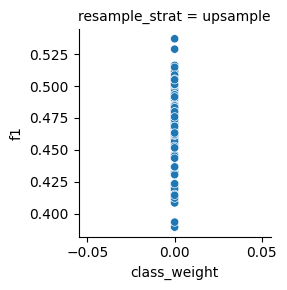

In [312]:
g=sns.FacetGrid(data=score_df, col='resample_strat')
g.map_dataframe(sns.scatterplot, x='class_weight', y='f1', style='classifier')
# g.add_legend()
plt.show()

# Model training
Using hyperparams from previous stage, try training model with different feature subsets.

Since we're using wildly different numbers of features, tune depth again.

In [313]:
pos_feats = [col for col in feat_cols if 'pos' in col]
len_feats = [col for col in feat_cols if 'len' in col]
freq_feats = [col for col in feat_cols if 'freq' in col]
identity_feats = [col for col in feat_cols if 'same' in col]
prev_word_feats = [col for col in feat_cols if col.startswith('prev')]
curr_word_feats = [col for col in feat_cols if col.startswith('word')]
next_word_feats = [col for col in feat_cols if col.startswith('next')]
feat_groups = {
    "all": feat_cols,
    "pos": pos_feats,
    "len": len_feats,
    "frequency": freq_feats,
    "identity": identity_feats,
    "prev_word": prev_word_feats,
    "curr_word": curr_word_feats,
    "next_word": next_word_feats,
}

In [315]:
sub_sample_ratio = 0.1
ins_sample_ratio = 0.2
class_weight = None
resample_funct = upsample

train_scores = []
train_df = resample_funct(sub_sample_ratio, ins_sample_ratio, train_df=df)
y = train_df['edit_type'].copy().to_numpy()
# y= (y>0)
# np.random.shuffle(y)

for depth in tqdm(range(1,21)):
    tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=depth)
    for feat_name, feats in feat_groups.items():
    # for feat_name, feats in [("frequency", freq_feats)]:
        X = train_df[feats].to_numpy()
        X_test = test_df[feats].to_numpy()
        tree_clf.fit(X, y)
        y_hat = tree_clf.predict(X_test)
        f1_score = sklearn.metrics.f1_score(y_test, y_hat, average='macro')
        # f1_score = sklearn.metrics.f1_score(y_test>0, y_hat)
        train_scores.append({
            "depth": depth,
            # "hit_f1": f1_score[0],
            # "sub_f1": f1_score[1],
            # "ins_f1": f1_score[2],
            "f1": f1_score,
            "features": feat_name,
        })

train_score_df = pd.DataFrame(train_scores)

100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


In [321]:
sklearn.metrics.f1_score(y_test, np.zeros_like(y_test), average='macro')

0.32532159783344616

In [316]:
# train_score_df['error_f1']=(train_score_df['sub_f1']+train_score_df['ins_f1'])/2
# train_score_df.sort_values(['error_f1', 'sub_f1', 'ins_f1'], ascending=False)
train_score_df.sort_values(['f1'], ascending=False)

,depth,f1,features
32,5,0.537166,all
24,4,0.520882,all
40,6,0.493814,all
56,8,0.492811,all
48,7,0.492494,all
...,...,...,...
7,1,0.325322,next_word
1,1,0.325322,pos
2,1,0.325322,len
23,3,0.325302,next_word


In [318]:
train_score_df.pivot_table(index=['features'], values=['f1'], aggfunc='max')

,f1
features,
all,0.537166
curr_word,0.452348
frequency,0.432871
identity,0.393653
len,0.393705
next_word,0.393089
pos,0.372350
prev_word,0.394069


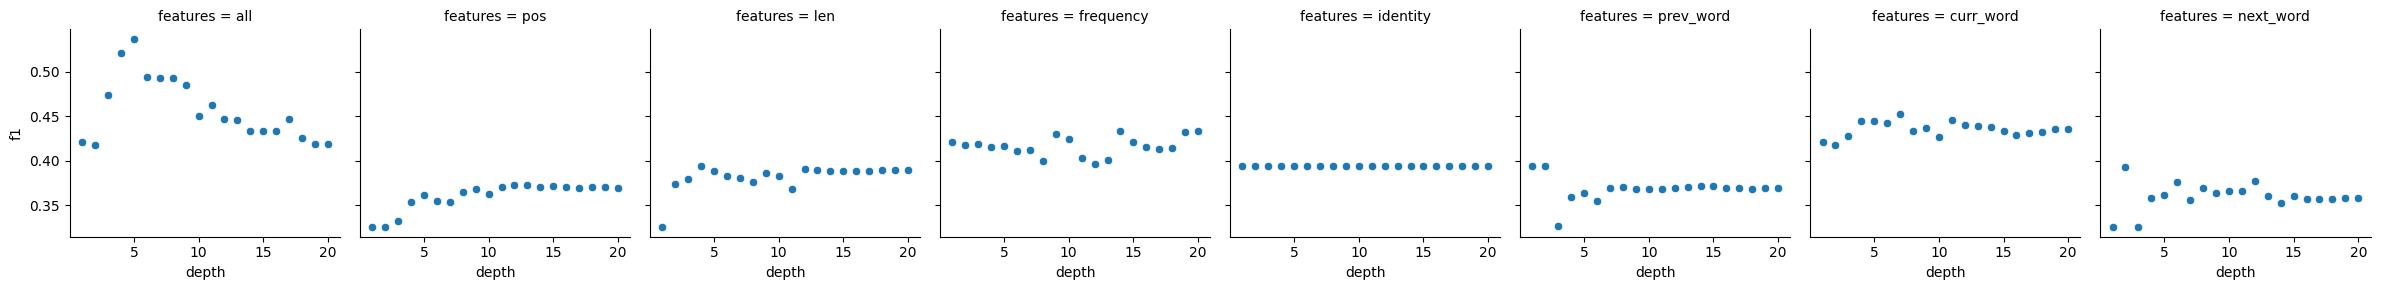

In [320]:
g=sns.FacetGrid(data=train_score_df, col='features', sharex=False)
g.map_dataframe(sns.scatterplot, x='depth', y='f1')
g.add_legend()
# g=sns.scatterplot(data=train_score_df, x='depth', y='error_f1', hue='features')
plt.show()

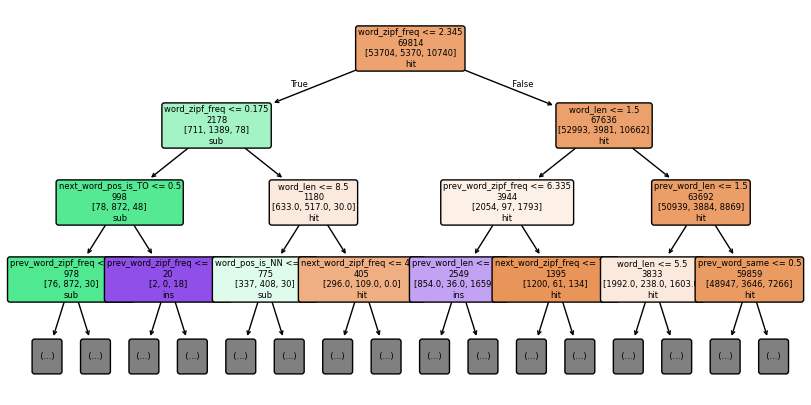

In [ ]:
plt.figure(figsize=(10, 5))
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=5)
X = train_df[feat_cols].to_numpy()
X_test = test_df[feat_cols].to_numpy()
tree_clf.fit(X, y)
sklearn.tree.plot_tree(
    tree_clf,
    feature_names=feat_cols, 
    class_names=['hit', 'sub', 'ins'],
    fontsize=6,
    impurity=False,
    label='none',
    filled=True,
    rounded=True,
    max_depth=3,
)
plt.show()

In [339]:
print(sklearn.tree.export_text(tree_clf, feature_names=feat_cols))

|--- word_zipf_freq <= 2.34
|   |--- word_zipf_freq <= 0.17
|   |   |--- next_word_pos_is_TO <= 0.50
|   |   |   |--- prev_word_zipf_freq <= 7.71
|   |   |   |   |--- word_pos_is_CD <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- word_pos_is_CD >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- prev_word_zipf_freq >  7.71
|   |   |   |   |--- next_word_len <= 2.50
|   |   |   |   |   |--- class: 3.0
|   |   |   |   |--- next_word_len >  2.50
|   |   |   |   |   |--- class: 1.0
|   |   |--- next_word_pos_is_TO >  0.50
|   |   |   |--- prev_word_zipf_freq <= 3.21
|   |   |   |   |--- class: 3.0
|   |   |   |--- prev_word_zipf_freq >  3.21
|   |   |   |   |--- class: 0.0
|   |--- word_zipf_freq >  0.17
|   |   |--- word_len <= 8.50
|   |   |   |--- word_pos_is_NN <= 0.50
|   |   |   |   |--- prev_word_zipf_freq <= 4.45
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- prev_word_zipf_freq >  4.45
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- word_po

# Baseline
What scores do we get by guessing randomly?

In [ ]:
y.value_counts()

edit_type
0.0    53704
3.0    10740
1.0     5370
Name: count, dtype: int64